## Setup, Loading Data and CDFs

In [11]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'stft-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [12]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_stft_1e5rawcomp_ravdess.ipynb


In [13]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\stft\\statement_2'

In [14]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [15]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))


In [16]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [17]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


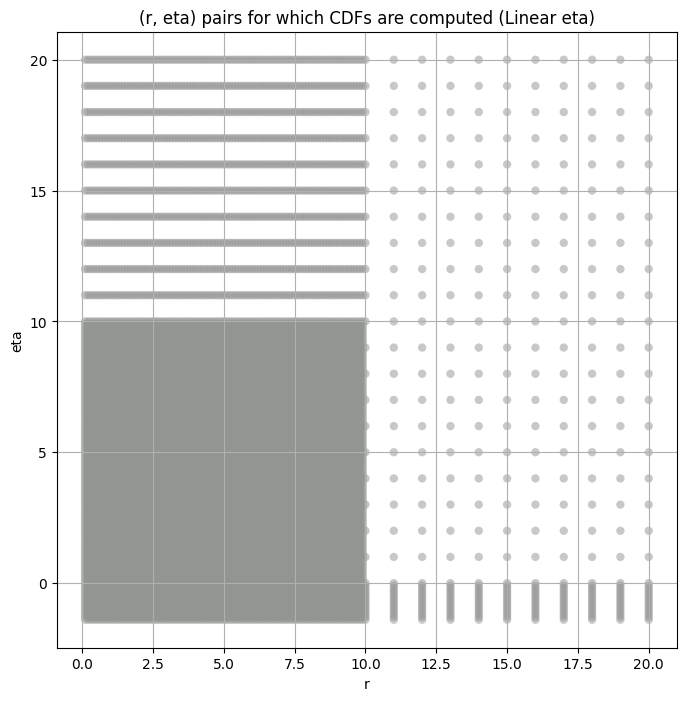

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [18]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [19]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [20]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     68.238930  55.853195  88.277690   78.60785   22.801790   260.92975   
3     29.261380  23.565706  41.711970  131.73262   23.337027   507.65482   
4     29.676050  23.769623  42.169933  130.15865   29.780775   507.69504   
5     16.709303  13.237209  24.569920  157.44476   33.269300   601.07715   
6      4.573166   3.469207   7.863290  323.61923   36.913420  1073.44250   
7      1.101603   0.858899   1.745578  222.43742   33.257880   816.22186   
8      0.427903   0.339047   0.593751  118.09703   37.517390   437.80756   
9      0.312102   0.231882   0.484675  221.03058   55.075670   742.60030   

      total_samples  
band                 
2          100000.0  
3          100000.0  
4          100000.0  
5          100000.0  
6          100000.0  
7          100000.0  
8          100000.0  
9          100000.0

## Initial Grid Search and Hypothesis Test Plots

In [21]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [22]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     68.238930      68.238930       59.104847       55.518093   
3     29.261380      29.261379       24.919544       23.418655   
4     29.676050      29.676050       25.607506       24.002270   
5     16.709303      16.709303       14.297024       13.365449   
6      4.573166       4.573166        3.739477        3.469503   
7      1.101603       1.101603        0.929288        0.868440   
8      0.427903       0.427904        0.370381        0.344618   
9      0.312102       0.312102        0.254372        0.230867   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2          52.968063        50.944801        47.797012        45.344231   
3          22.331747        21.460054        20.090960        19.018438   
4          22.774183        21.758524        20.112394        18.789886   
5          12.651515        12.057552        11.090414        10.310281   
6           3.266947         3.101331         2.836205         2.625757   
7           0.821871         0.783299         0.720512         0.669852   
8           0.324545         0.307780         0.280484         0.258565   
9           0.213211         0.198875         0.176193         0.158589   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2           43.319778        41.585758        40.063259        36.359600  
3           18.131485        17.372625        16.709185        15.102668  
4           17.679218        16.720581        15.877490        13.838980  
5            9.652403         9.083267         8.581675         7.362092  
6            2.450451         2.300047         2.168431         1.852478  
7            0.627150         0.590199         0.557632         0.478610  
8            0.240221         0.224468         0.210698         0.177785  
9            0.144270         0.132262         0.121980         0.098309

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.005996150177266291 68.23893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0036143849672944928 59.104847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.006609135939063426 55.518093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005732035850185557 52.968063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0034144797114264436 50.9448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.005481250741595556 47.797012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0067317451147072965 45.34423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0074485101032380485 43.31978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.007679574757199714 41.58576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.006674612886868041 40.06326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008127362973955086 36.3596
Number of samples: 100000, Without approximation : 100000.0


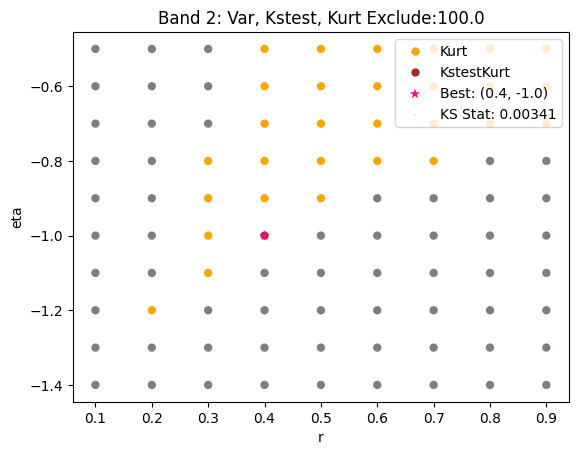

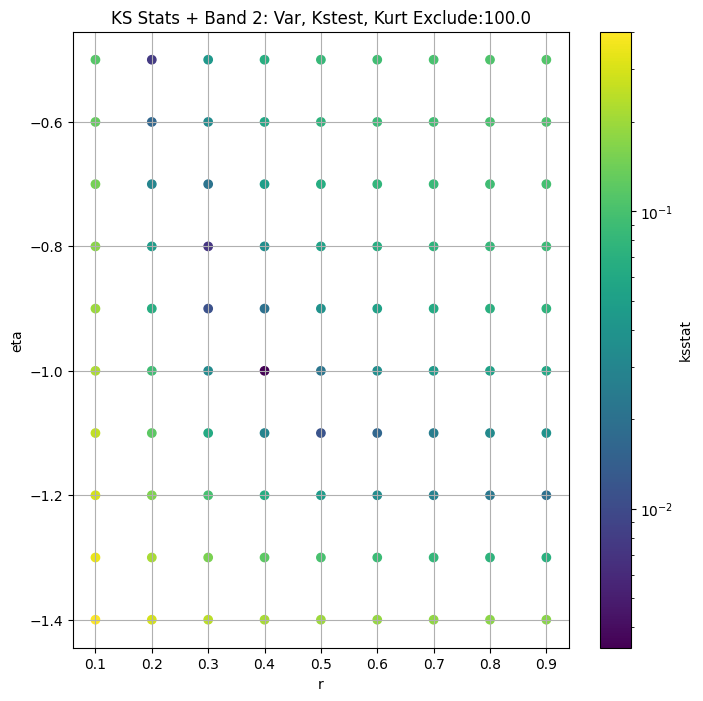

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.007976362883566124 29.26138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.005099899565826793 24.919544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.003415550762574493 23.418655


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.005629023558371693 22.331747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.004725881047233815 21.460054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.00295450509947702 20.09096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.0044271221406993536 19.018438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.006011645764961715 18.131485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.0048962013127378 17.372625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.005650186259422443 16.709185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.007670308080766183 15.102668
Number of samples: 100000, Without approximation : 100000.0


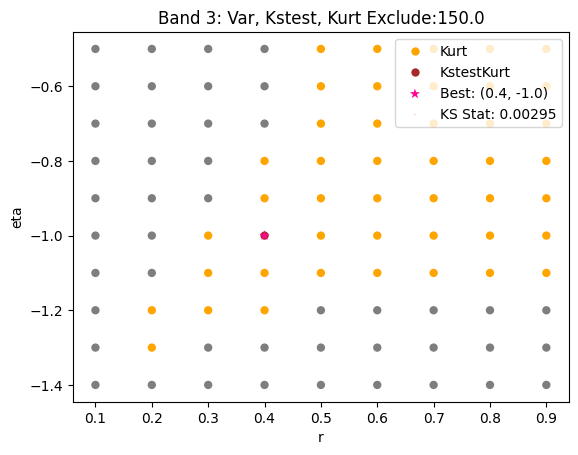

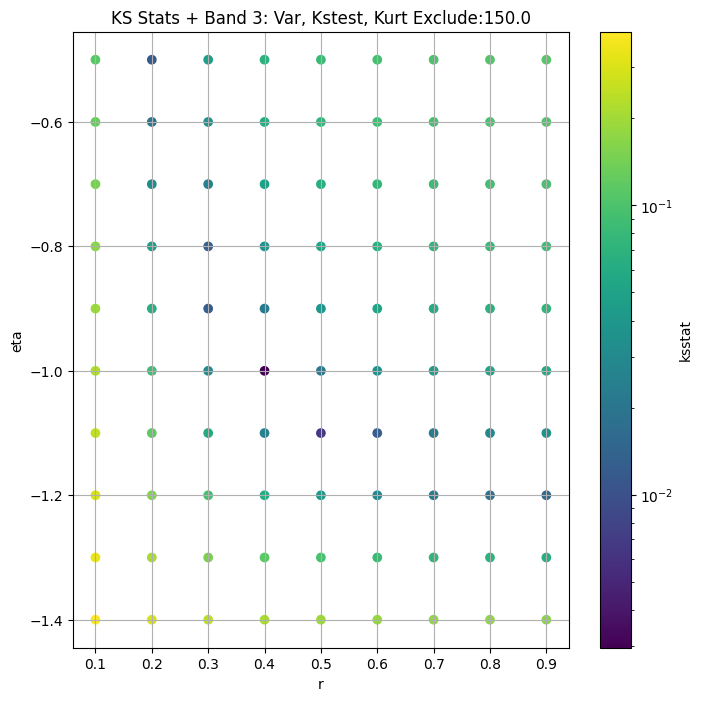

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.008596822190999776 29.67605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.002613707357700208 25.607506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.0035191564144241745 24.00227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0061119902349899 22.774183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.008620851940964791 21.758524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011798151763381615 20.112394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010150701620794234 18.789886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008013831250410441 17.679218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.009604272417185061 16.720581


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.010247220340749208 15.87749


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008614789136897335 13.83898
Number of samples: 100000, Without approximation : 100000.0


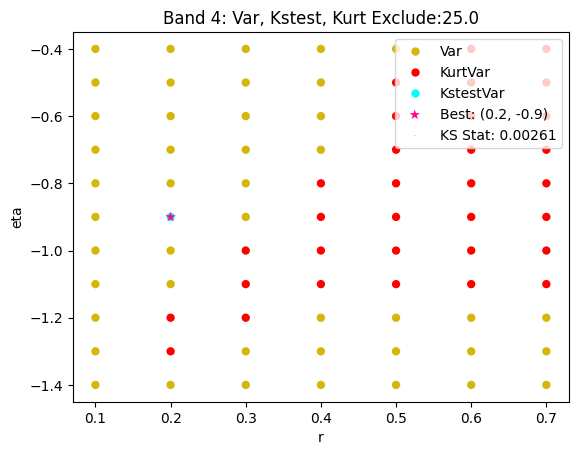

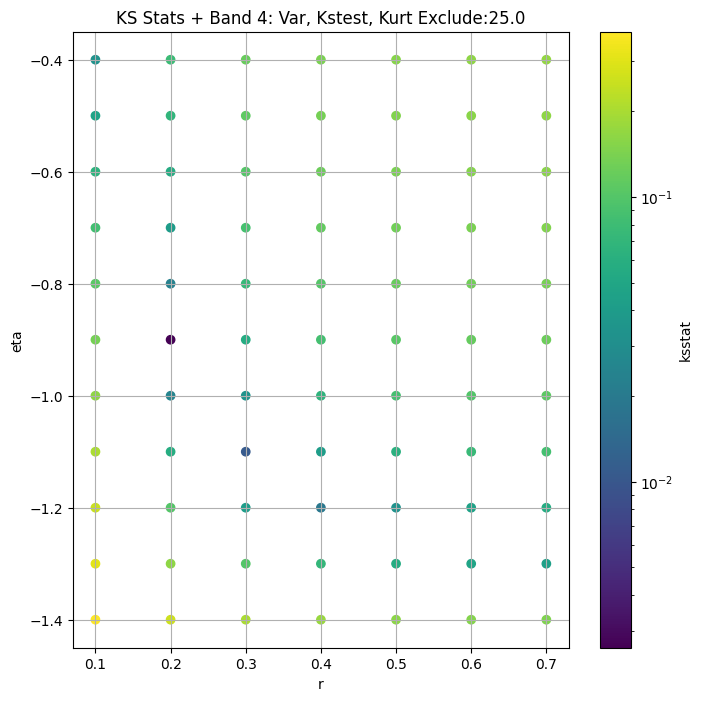

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.012716405233363148 16.709303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.007083533255814775 14.297024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008133280017220995 13.365449


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.009018752902744152 12.651515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008510714178832608 12.057552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00984414735211802 11.090414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.00995301864159007 10.310281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.011020353609850285 9.652403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01181181042562307 9.083267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009933983886403791 8.581675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.012366578610222601 7.362092
Number of samples: 100000, Without approximation : 100000.0


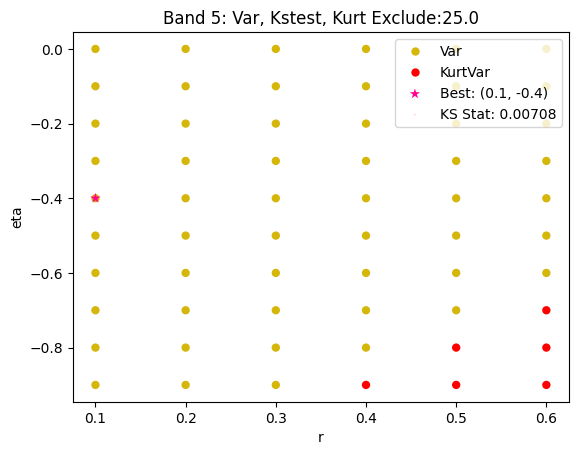

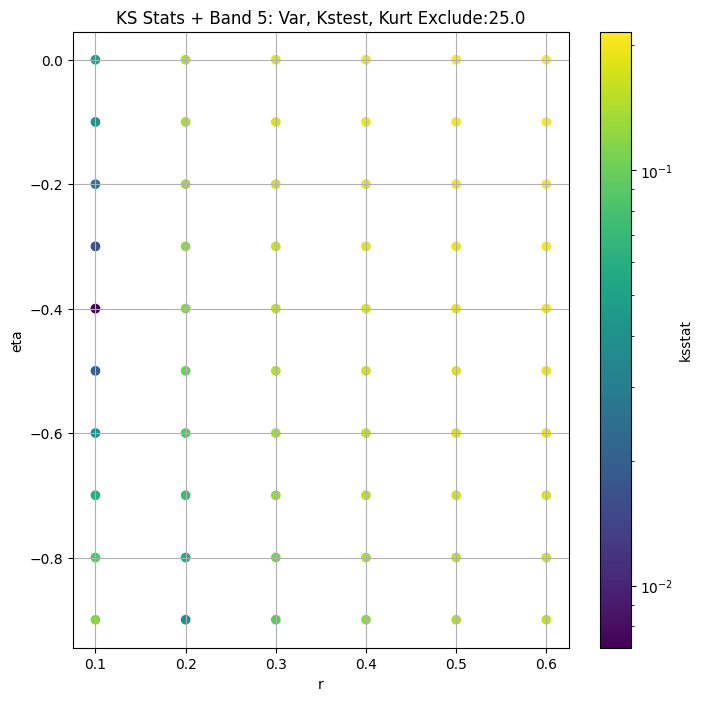

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012363658843216552 4.5731664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01186367158614221 3.7394767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.008049299877820881 3.4695032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009054989995587903 3.2669466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.011177319602049485 3.1013305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008308555583518774 2.8362052


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.00947121181952676 2.6257565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.009725307952758794 2.450451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01070012687838793 2.3000472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.010930606815493404 2.168431


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.011127664495058146 1.8524783
Number of samples: 100000, Without approximation : 100000.0


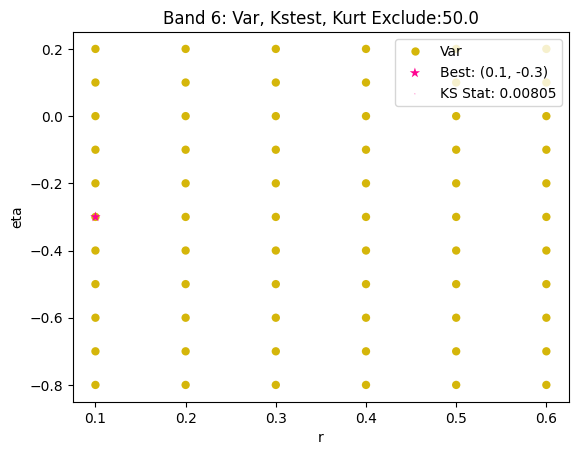

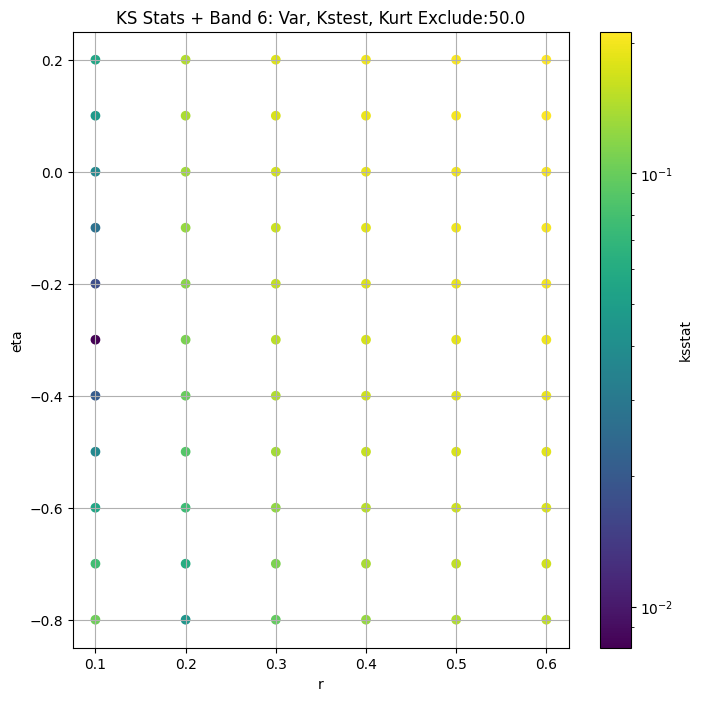

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.013401125297072936 1.1016032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.010854407830420576 0.9292878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.010807310906751466 0.86844003


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.012440655621365204 0.8218712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009740618925589528 0.78329927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0077015566024716264 0.72051185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.008744720969032838 0.6698524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.00900844065053644 0.62714976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.009383914567970358 0.5901989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.010239801261675997 0.5576319


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.011977073092762414 0.47860953
Number of samples: 100000, Without approximation : 100000.0


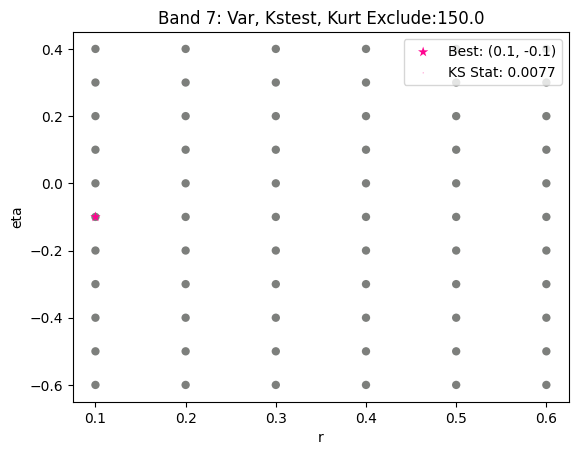

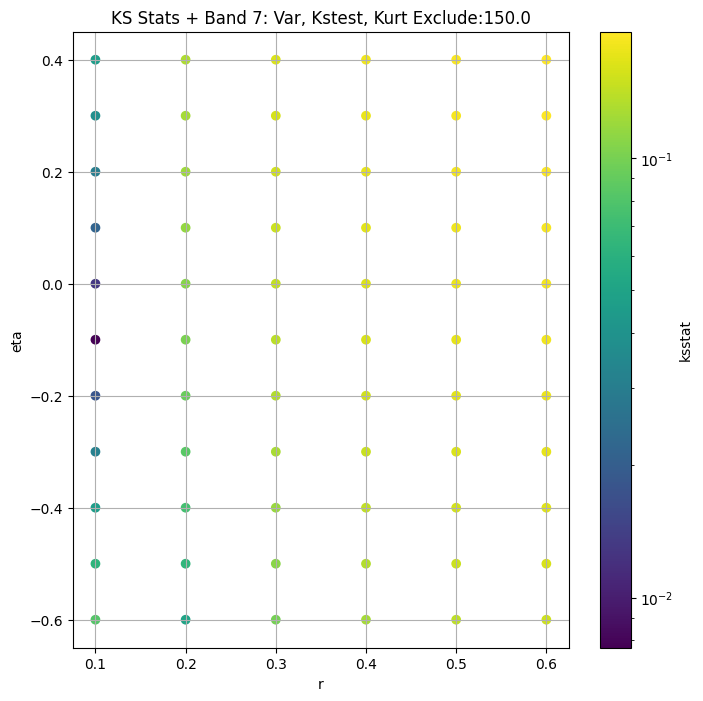

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.019510517464051247 0.4279035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.015021413685370799 0.3703812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.016189061552404627 0.34461805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01589727945631103 0.32454515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.012983390795034966 0.30778018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.013786813463261494 0.28048375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01070621779915304 0.2585653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.010601478109706963 0.24022111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009604681433773465 0.22446834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.008905691390210668 0.21069837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010521705263246733 0.17778514
Number of samples: 100000, Without approximation : 100000.0


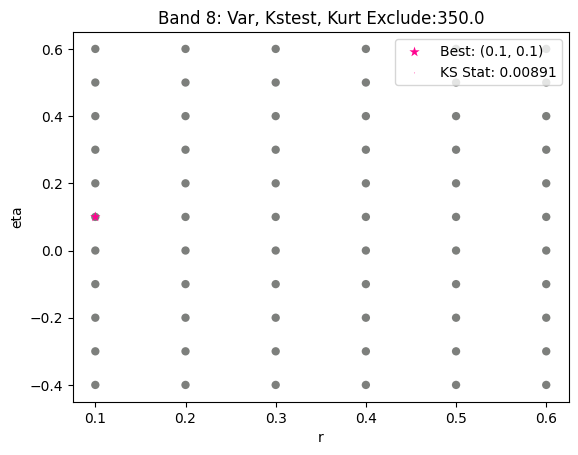

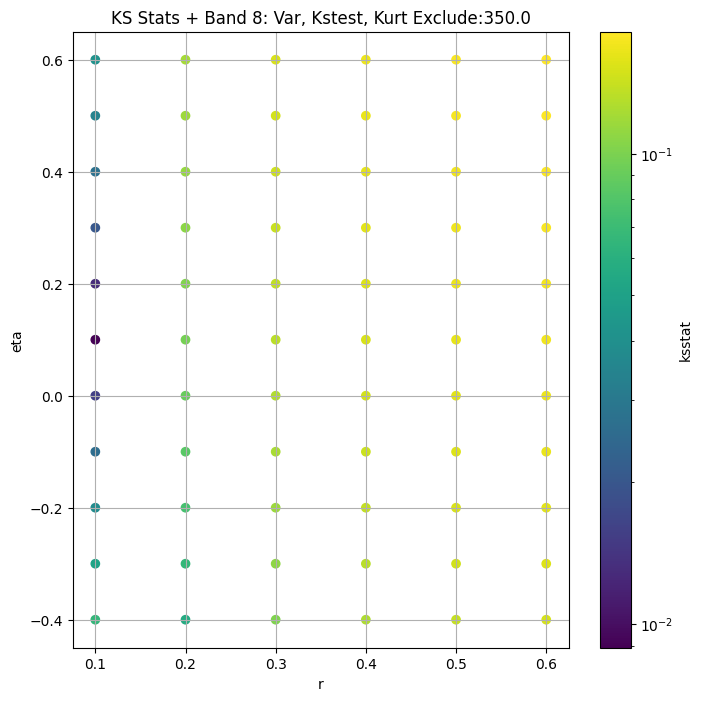

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01972014760405405 0.3121021


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.020057830541141186 0.25437167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.015504244263240485 0.23086661


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.014179945917181802 0.21321058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.016957236476265736 0.19887458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.01125264995524311 0.1761926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.012545660844485218 0.15858932


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.009269546605204543 0.1442703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.00795188706737443 0.1322616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00819044415271264 0.12198005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009565910260012592 0.09830942
Number of samples: 100000, Without approximation : 100000.0


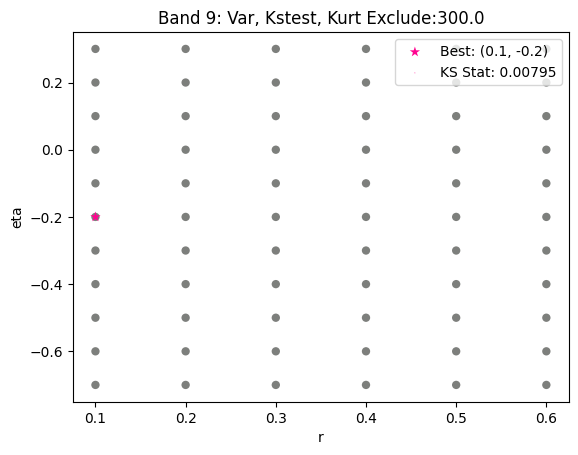

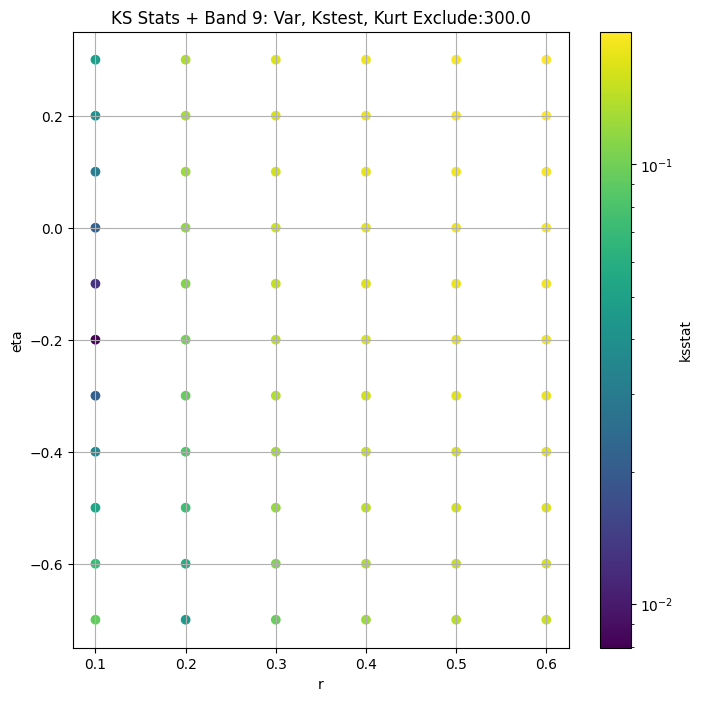

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     68.238930  55.853195  88.277690   78.60785   22.801790   260.92975   
3     29.261380  23.565706  41.711970  131.73262   23.337027   507.65482   
4     29.676050  23.769623  42.169933  130.15865   29.780775   507.69504   
5     16.709303  13.237209  24.569920  157.44476   33.269300   601.07715   
6      4.573166   3.469207   7.863290  323.61923   36.913420  1073.44250   
7      1.101603   0.858899   1.745578  222.43742   33.257880   816.22186   
8      0.427903   0.339047   0.593751  118.09703   37.517390   437.80756   
9      0.312102   0.231882   0.484675  221.03058   55.075670   742.60030   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003414        0.4         -1.0   
3          100000.0             0.002955        0.4         -1.0   
4          100000.0             0.002614        0.2         -0.9   
5          100000.0             0.007084        0.1         -0.4   
6          100000.0             0.008049        0.1         -0.3   
7          100000.0             0.007702        0.1         -0.1   
8          100000.0             0.008906        0.1          0.1   
9          100000.0             0.007952        0.1         -0.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.044011e+01                   100.0           50.944800   
3      4.117238e+00                   150.0           20.090960   
4      1.016171e-02                    25.0           25.607506   
5      2.132476e-11                    25.0           14.297024   
6      2.710685e-12                    50.0            3.469503   
7      1.735510e-13                   150.0            0.720512   
8      1.776295e-14                   350.0            0.210698   
9      5.636431e-14                   300.0            0.132262   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
3                    0.004293  
4                    0.004293  
5                    0.004293  
6                    0.004293  
7                    0.004293  
8                    0.004293  
9                    0.004293

In [23]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [24]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.004260298812769254, var: 45.34423065185547


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.0037934907235449462, var: 46.50483322143555


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.0033064503791318915, var: 47.79701232910156


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.002861550431076023, var: 49.256675720214844


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.0029490593016653355, var: 50.944801330566406


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.002287064469602331, var: 52.96806335449219


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.0019060777365081938, var: 55.51809310913086


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.0025367966003295717, var: 59.1048469543457


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.0035638166364871937, var: 68.23892974853516
Number of samples: 100000, Without approximation : 100000.0


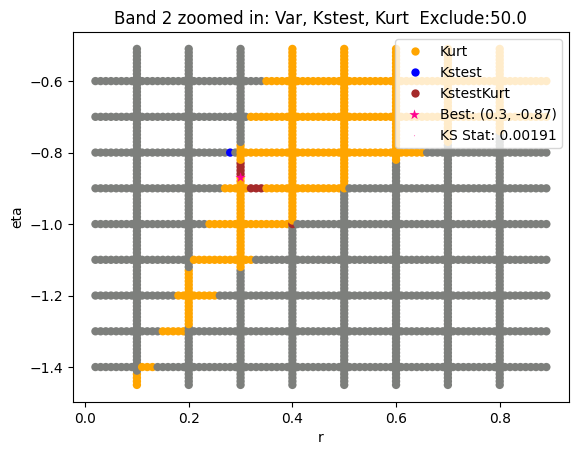

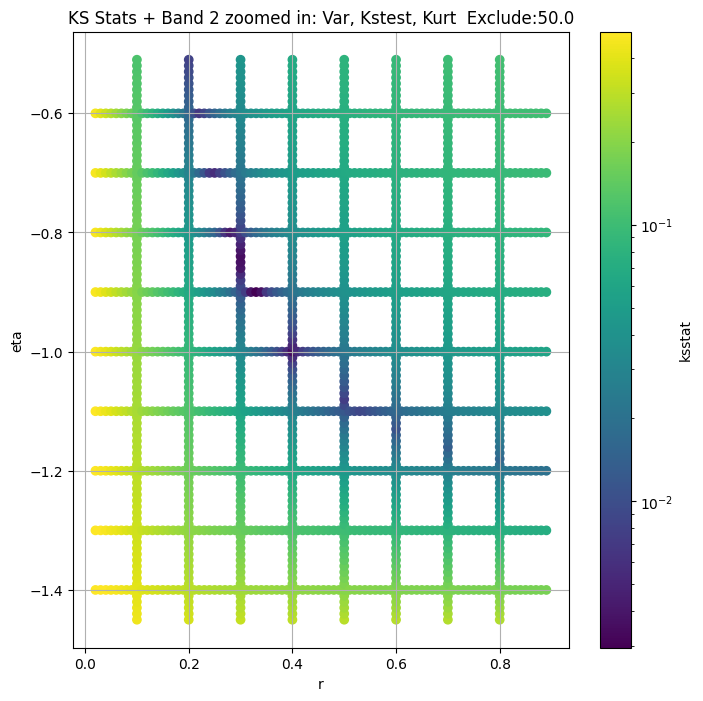

Band 3


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + 100 = 250, ksstat: 0.004167294156875133, var: 18.131484985351562


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + 75 = 225, ksstat: 0.003927439003926773, var: 18.556140899658203


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + 50 = 200, ksstat: 0.0035081732389173545, var: 19.0184383392334


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + 25 = 175, ksstat: 0.0034124890972496123, var: 19.526525497436523


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + 0 = 150, ksstat: 0.00295450509947702, var: 20.090959548950195


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + -25 = 125, ksstat: 0.0024330113477887792, var: 20.72719955444336


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + -50 = 100, ksstat: 0.001954556675755885, var: 21.460054397583008


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + -75 = 75, ksstat: 0.0015247130923792965, var: 22.33174705505371


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 3, 150.0 + -100 = 50, ksstat: 0.0016211720073711633, var: 23.418655395507812
Number of samples: 100000, Without approximation : 100000.0


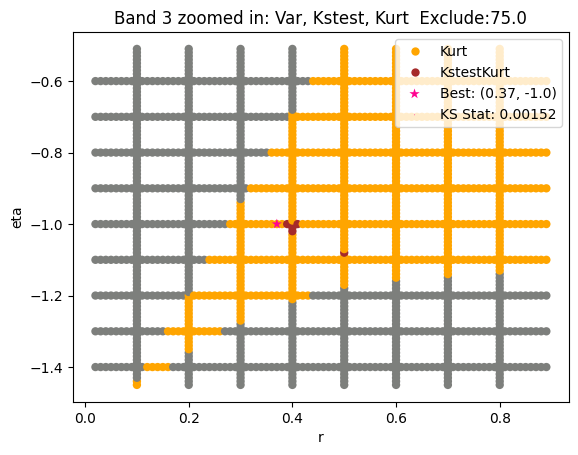

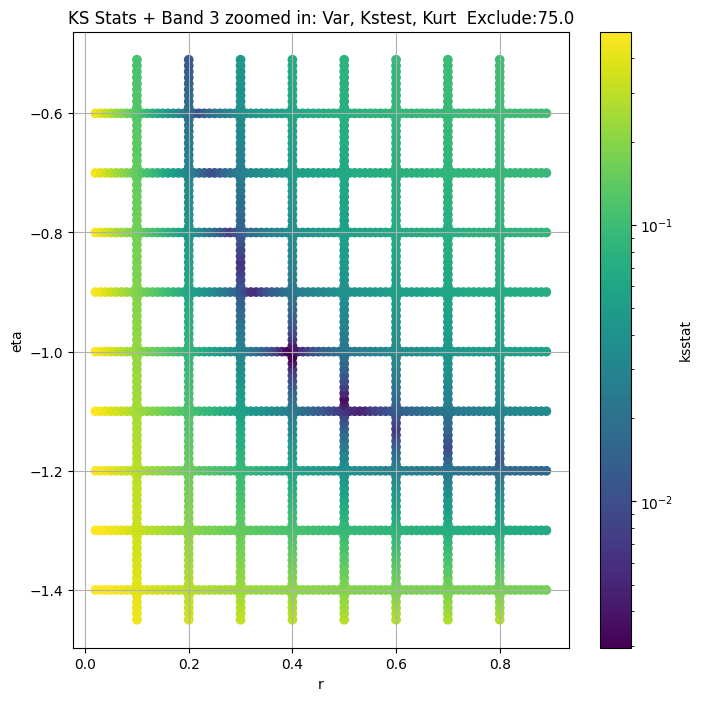

Band 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + 100 = 125, ksstat: 0.004376339058418947, var: 20.883514404296875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + 75 = 100, ksstat: 0.00393204152682991, var: 21.75852394104004


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + 50 = 75, ksstat: 0.004030940284742712, var: 22.77418327331543


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + 25 = 50, ksstat: 0.0034164212681025256, var: 24.002269744873047


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + 0 = 25, ksstat: 0.002613707357700208, var: 25.607505798339844


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 25.0 + -25 = 0, ksstat: 0.0030715308698562316, var: 29.676050186157227
Number of samples: 100000, Without approximation : 100000.0


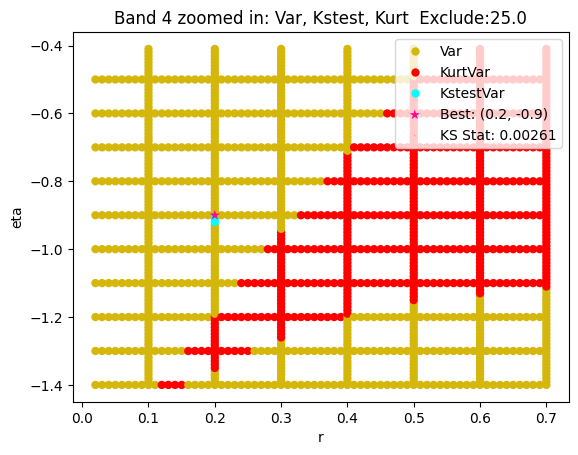

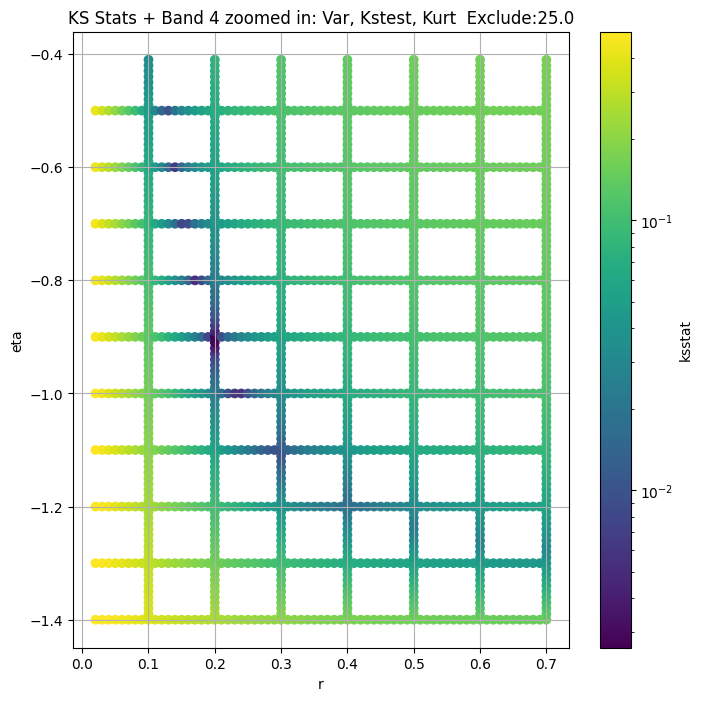

Band 5


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.008002933607468062, var: 11.544271469116211


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.008402326040555089, var: 12.057552337646484


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.007990300390113392, var: 12.651515007019043


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.007175111515498232, var: 13.365448951721191


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.0068973236506919, var: 14.29702377319336


  0%|          | 0/927 [00:00<?, ?it/s]

Finding Minimum after computing 927 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.006761331492071643, var: 16.70930290222168
Number of samples: 100000, Without approximation : 100000.0


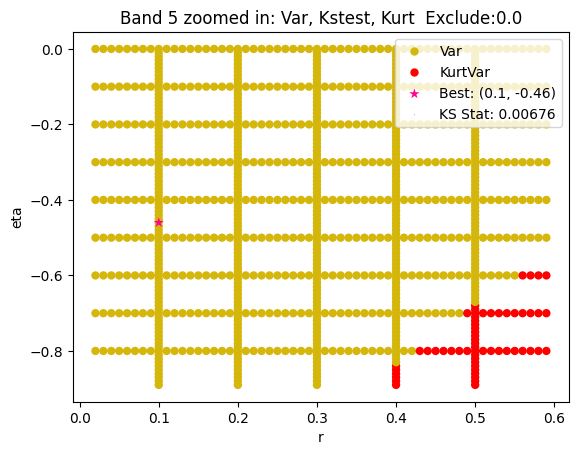

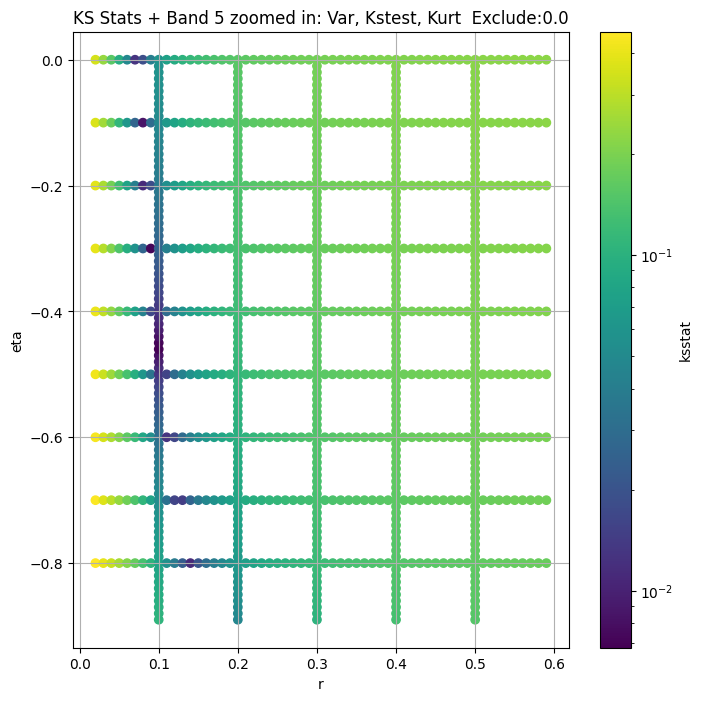

Band 6


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + 100 = 150, ksstat: 0.00815181168382794, var: 2.836205244064331


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + 75 = 125, ksstat: 0.007771624800553295, var: 2.959993839263916


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + 50 = 100, ksstat: 0.007434914724944612, var: 3.101330518722534


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + 25 = 75, ksstat: 0.006954858577098572, var: 3.26694655418396


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + 0 = 50, ksstat: 0.007968285197784586, var: 3.469503164291382


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + -25 = 25, ksstat: 0.007208206899669556, var: 3.7394766807556152


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 6, 50.0 + -50 = 0, ksstat: 0.010271770350041953, var: 4.573166370391846
Number of samples: 100000, Without approximation : 100000.0


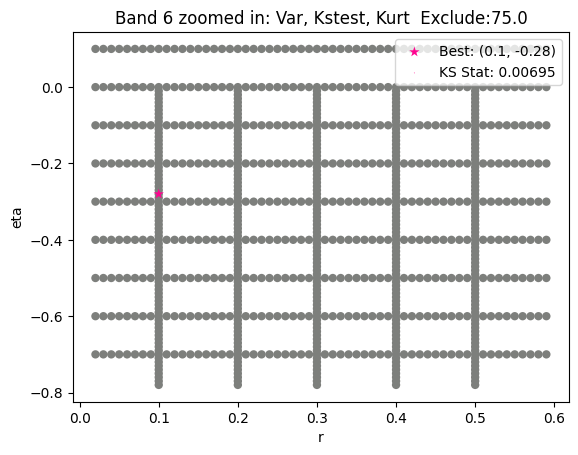

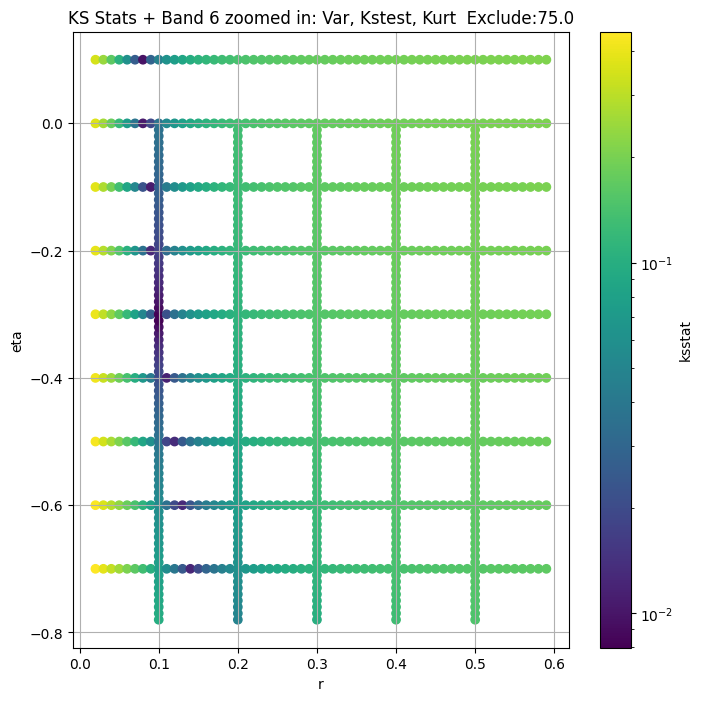

Band 7


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + 100 = 250, ksstat: 0.00843950510009428, var: 0.627149760723114


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + 75 = 225, ksstat: 0.007985684992493636, var: 0.6476670503616333


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + 50 = 200, ksstat: 0.008103092933177826, var: 0.6698523759841919


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + 25 = 175, ksstat: 0.007607259250146475, var: 0.6939882040023804


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + 0 = 150, ksstat: 0.007435504010632532, var: 0.7205118536949158


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + -25 = 125, ksstat: 0.0072200771617114134, var: 0.7499942183494568


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + -50 = 100, ksstat: 0.007567107020006791, var: 0.7832992672920227


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + -75 = 75, ksstat: 0.008369623163310524, var: 0.8218712210655212


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 150.0 + -100 = 50, ksstat: 0.007160612047489356, var: 0.8684400320053101
Number of samples: 100000, Without approximation : 100000.0


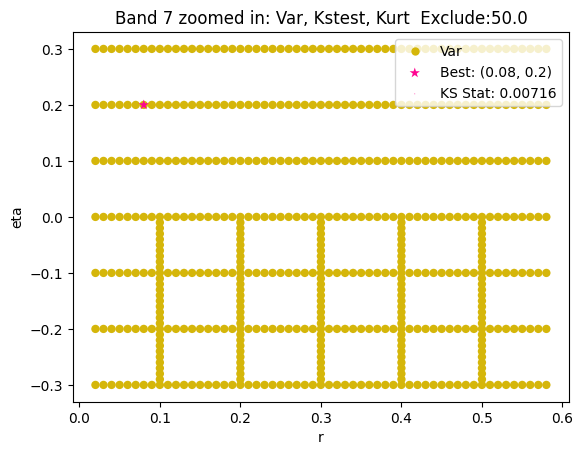

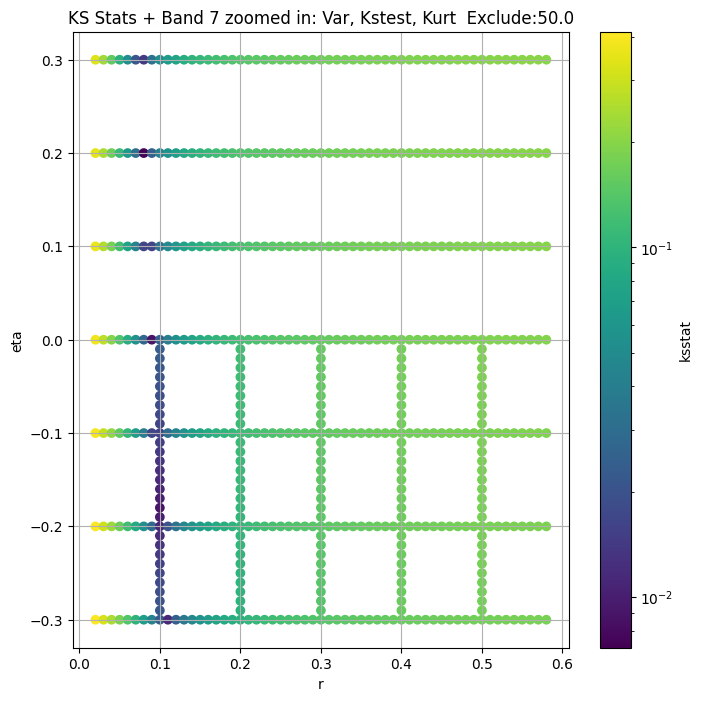

Band 8


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.009737828952036696, var: 0.18761393427848816


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.009662580706888434, var: 0.19291874766349792


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.009286226715449673, var: 0.19851349294185638


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.009302932063333344, var: 0.20442993938922882


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.008905691390210668, var: 0.21069836616516113


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.008512521403517607, var: 0.2173621952533722


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.00861546092426273, var: 0.22446833550930023


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.008194533887988327, var: 0.23206426203250885


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.009058115857706217, var: 0.24022111296653748
Number of samples: 100000, Without approximation : 100000.0


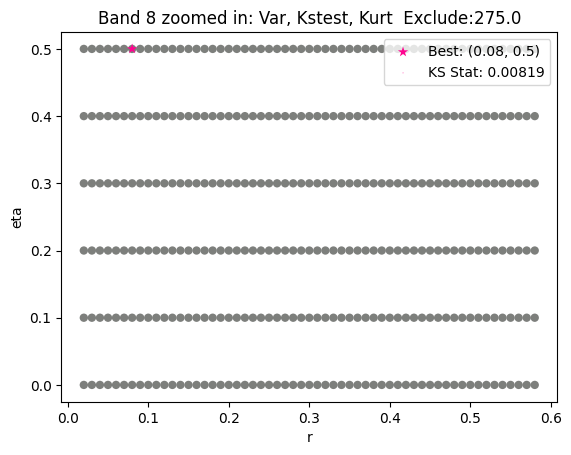

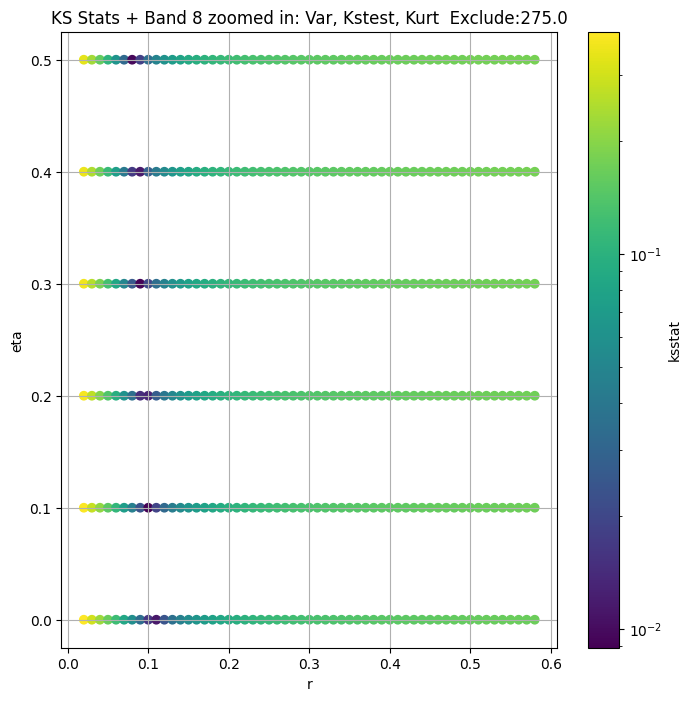

Band 9


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + 100 = 400, ksstat: 0.008314545905999445, var: 0.11305669695138931


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + 75 = 375, ksstat: 0.00803857463629488, var: 0.11736608296632767


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + 50 = 350, ksstat: 0.007575176159115281, var: 0.12198004871606827


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + 25 = 325, ksstat: 0.00738894484697037, var: 0.12693162262439728


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + 0 = 300, ksstat: 0.0071807634919326055, var: 0.13226160407066345


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + -25 = 275, ksstat: 0.00701201203517865, var: 0.13801907002925873


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + -50 = 250, ksstat: 0.007724920838557692, var: 0.14427030086517334


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + -75 = 225, ksstat: 0.008179856406904829, var: 0.1510954201221466


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 300.0 + -100 = 200, ksstat: 0.007296542844402745, var: 0.15858931839466095
Number of samples: 100000, Without approximation : 100000.0


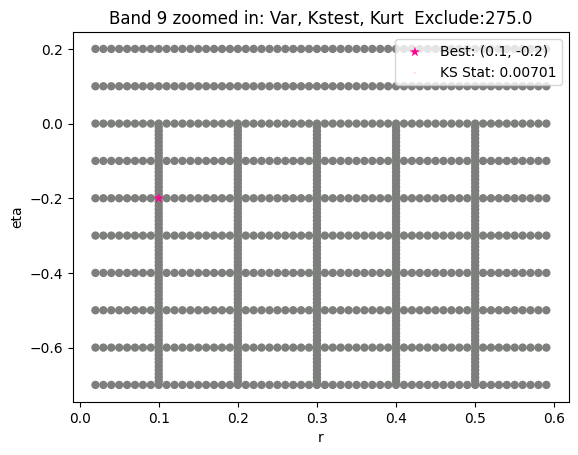

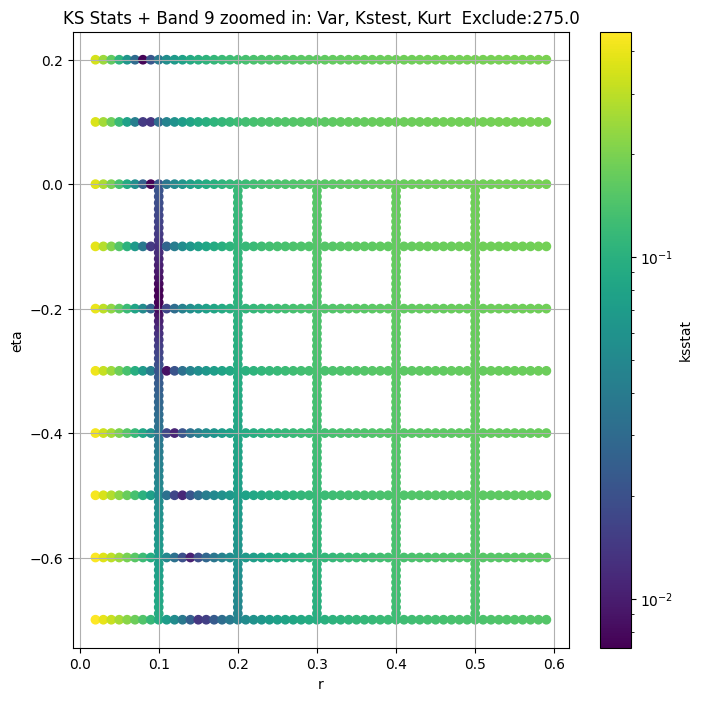

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     68.238930  55.853195  88.277690   78.60785   22.801790   260.92975   
3     29.261380  23.565706  41.711970  131.73262   23.337027   507.65482   
4     29.676050  23.769623  42.169933  130.15865   29.780775   507.69504   
5     16.709303  13.237209  24.569920  157.44476   33.269300   601.07715   
6      4.573166   3.469207   7.863290  323.61923   36.913420  1073.44250   
7      1.101603   0.858899   1.745578  222.43742   33.257880   816.22186   
8      0.427903   0.339047   0.593751  118.09703   37.517390   437.80756   
9      0.312102   0.231882   0.484675  221.03058   55.075670   742.60030   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003414        0.4         -1.0   
3          100000.0             0.002955        0.4         -1.0   
4          100000.0             0.002614        0.2         -0.9   
5          100000.0             0.007084        0.1         -0.4   
6          100000.0             0.008049        0.1         -0.3   
7          100000.0             0.007702        0.1         -0.1   
8          100000.0             0.008906        0.1          0.1   
9          100000.0             0.007952        0.1         -0.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.044011e+01                   100.0           55.518093   
3      4.117238e+00                   150.0           22.331747   
4      1.016171e-02                    25.0           25.607506   
5      2.132476e-11                    25.0           16.709303   
6      2.710685e-12                    50.0            3.266947   
7      1.735510e-13                   150.0            0.868440   
8      1.776295e-14                   350.0            0.232064   
9      5.636431e-14                   300.0            0.138019   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.001906    0.30     -0.87   
3                    0.004293          0.001525    0.37     -1.00   
4                    0.004293          0.002614    0.20     -0.90   
5                    0.004293          0.006761    0.10     -0.46   
6                    0.004293          0.006955    0.10     -0.28   
7                    0.004293          0.007161    0.08      0.20   
8                    0.004293          0.008195    0.08      0.50   
9                    0.004293          0.007012    0.10     -0.20   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.235275e+00                 50.0       506250  
3     3.097345e+00                 75.0       759375  
4     1.016171e-02                 25.0       284764  
5     3.754895e-11                  0.0        42187  
6     2.254099e-12                 75.0        37500  
7     1.246368e-18                 50.0        37500  
8     6.384768e-20                275.0        28125  
9     5.881789e-14                275.0        37500

In [25]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

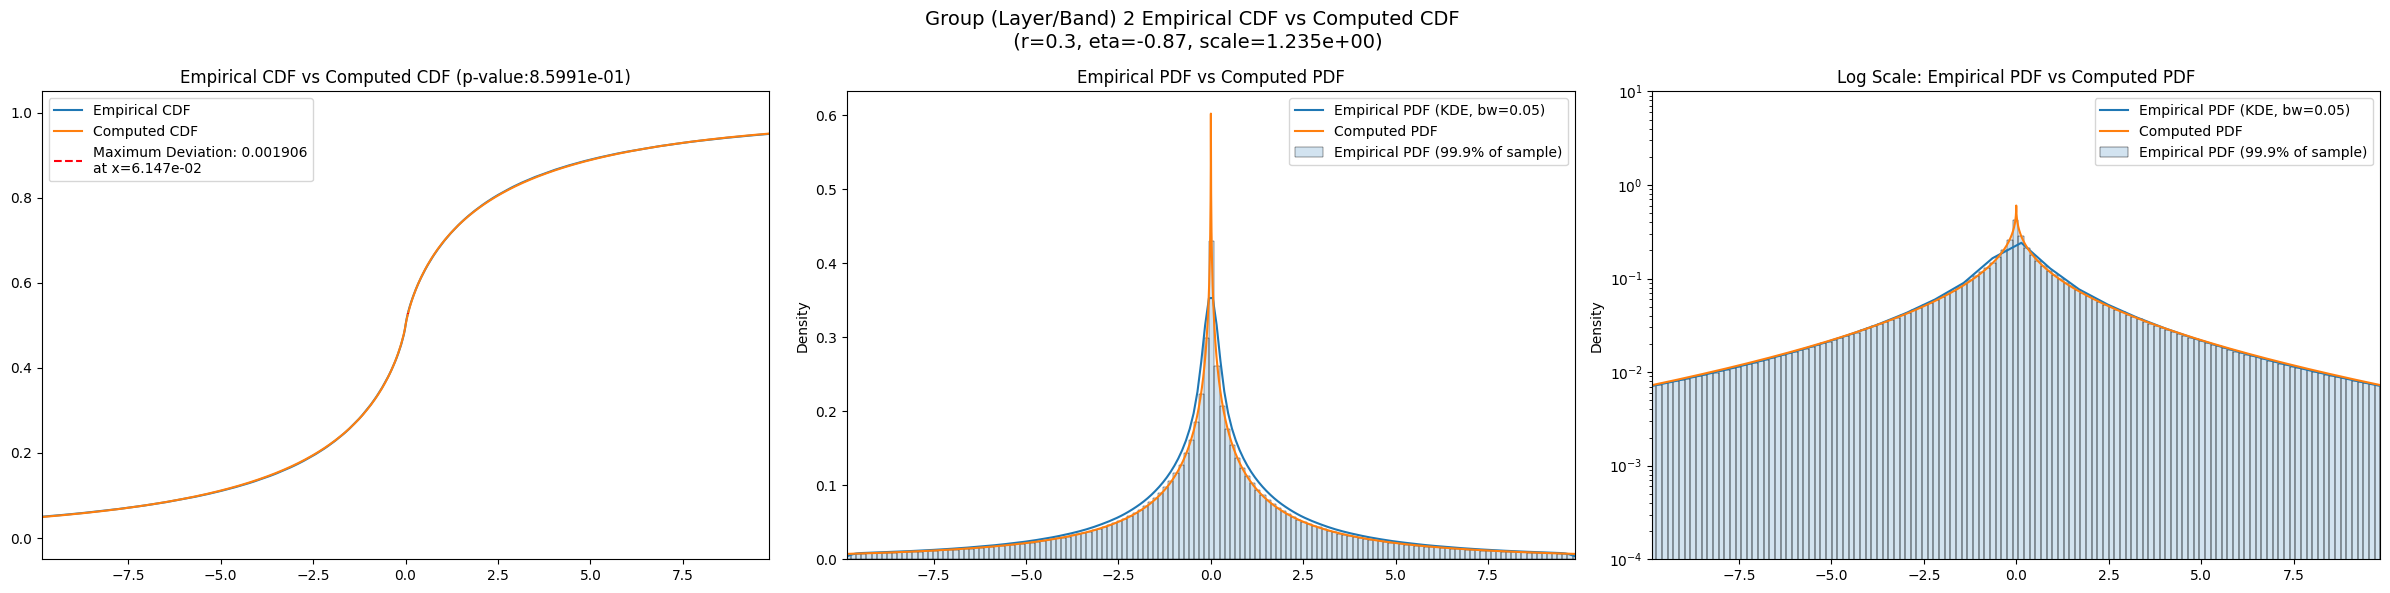

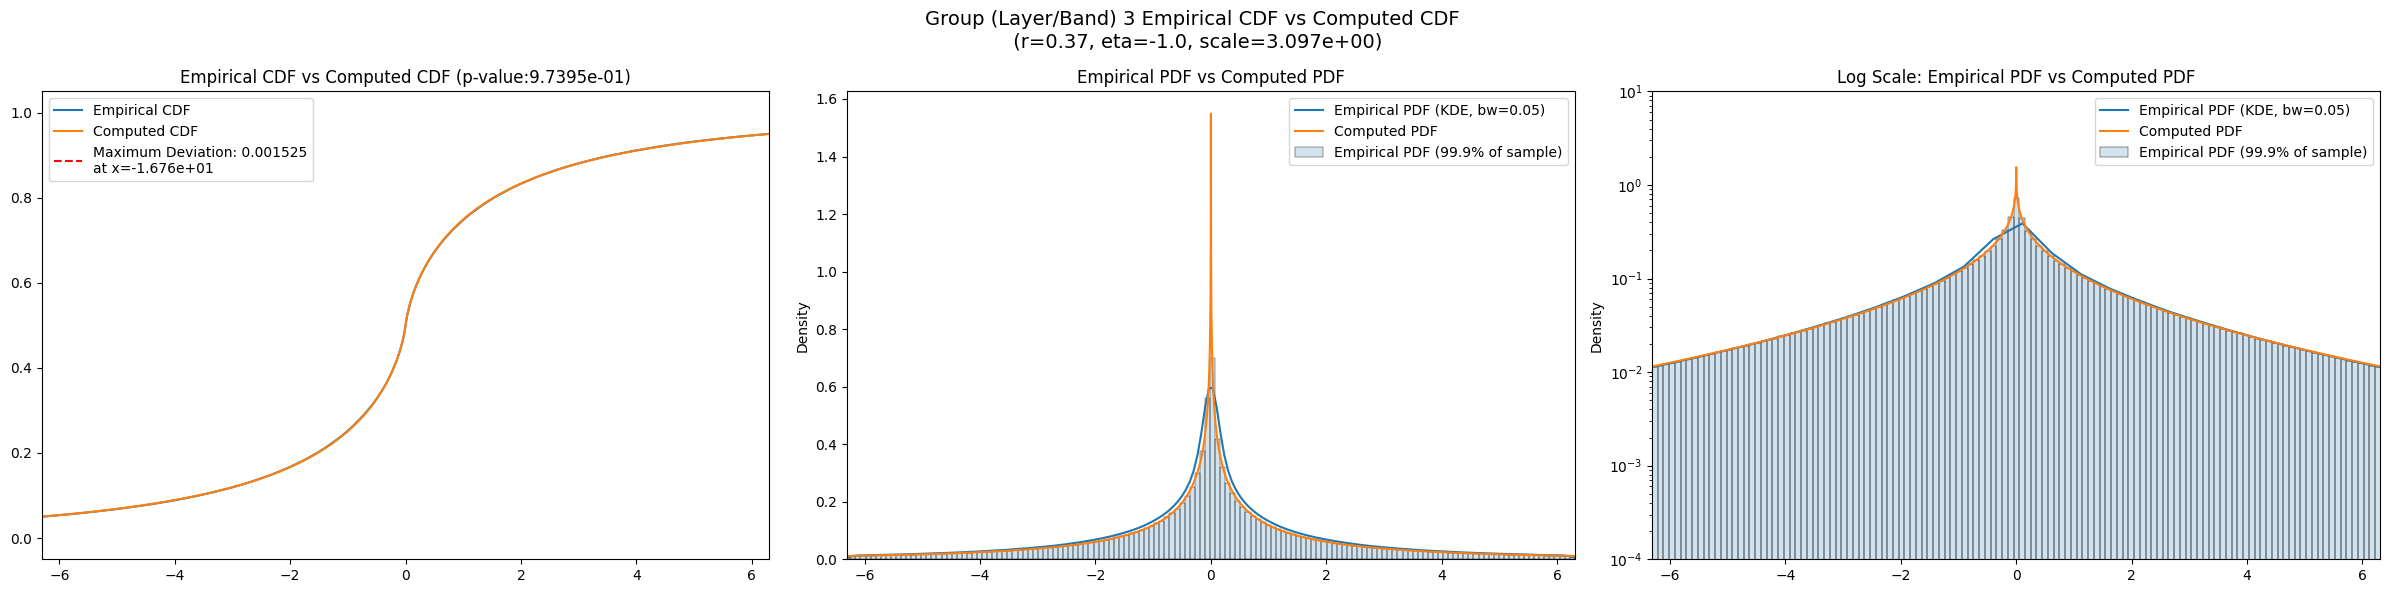

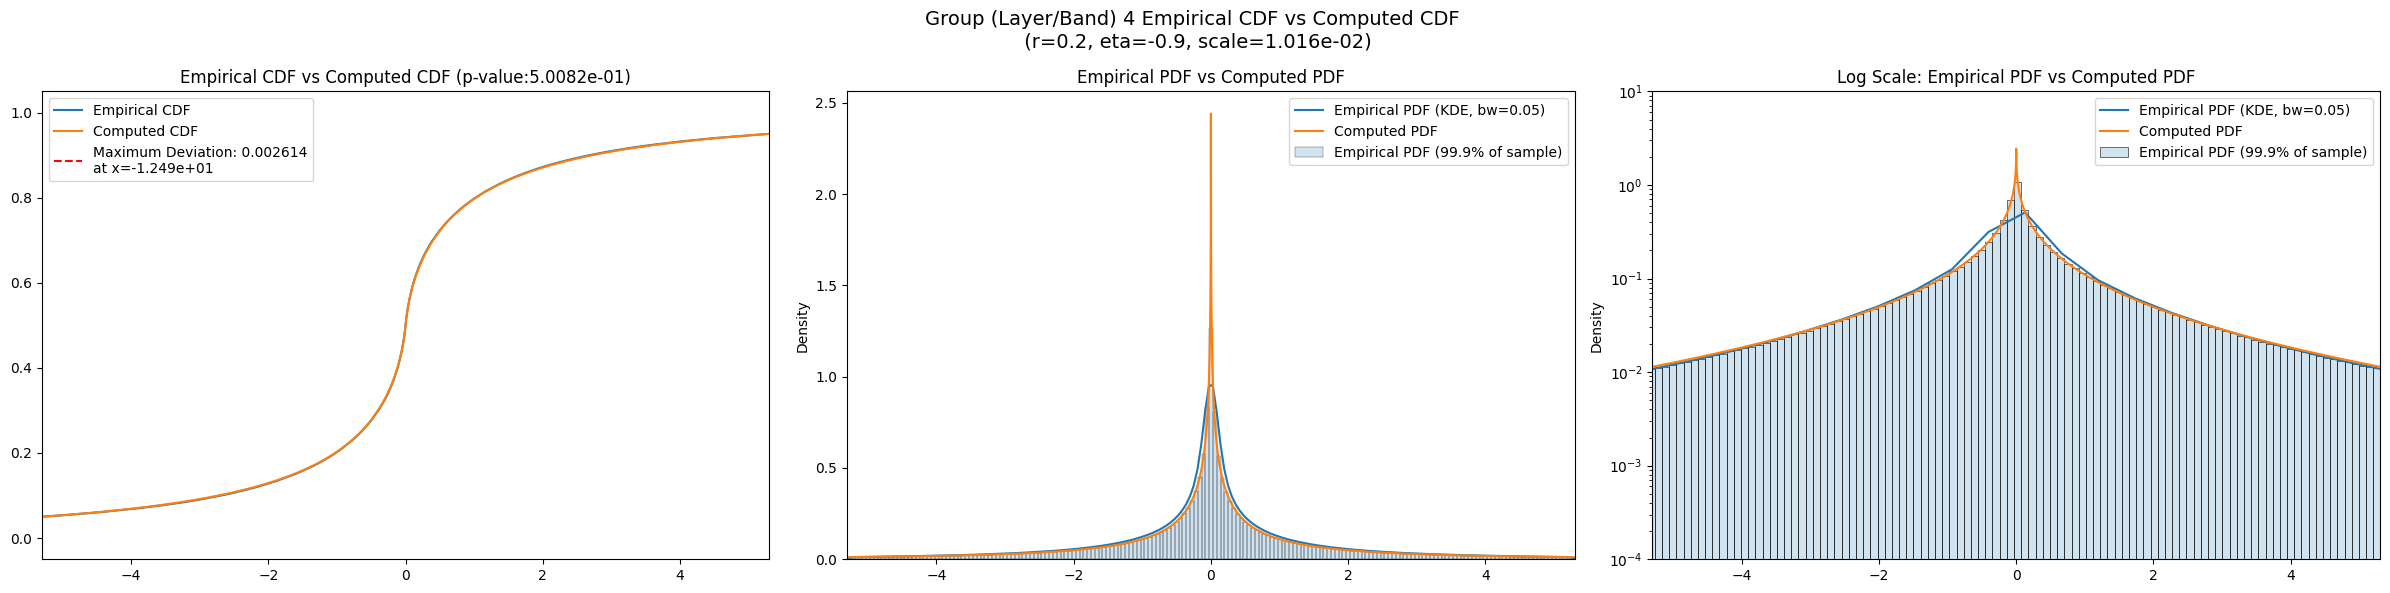

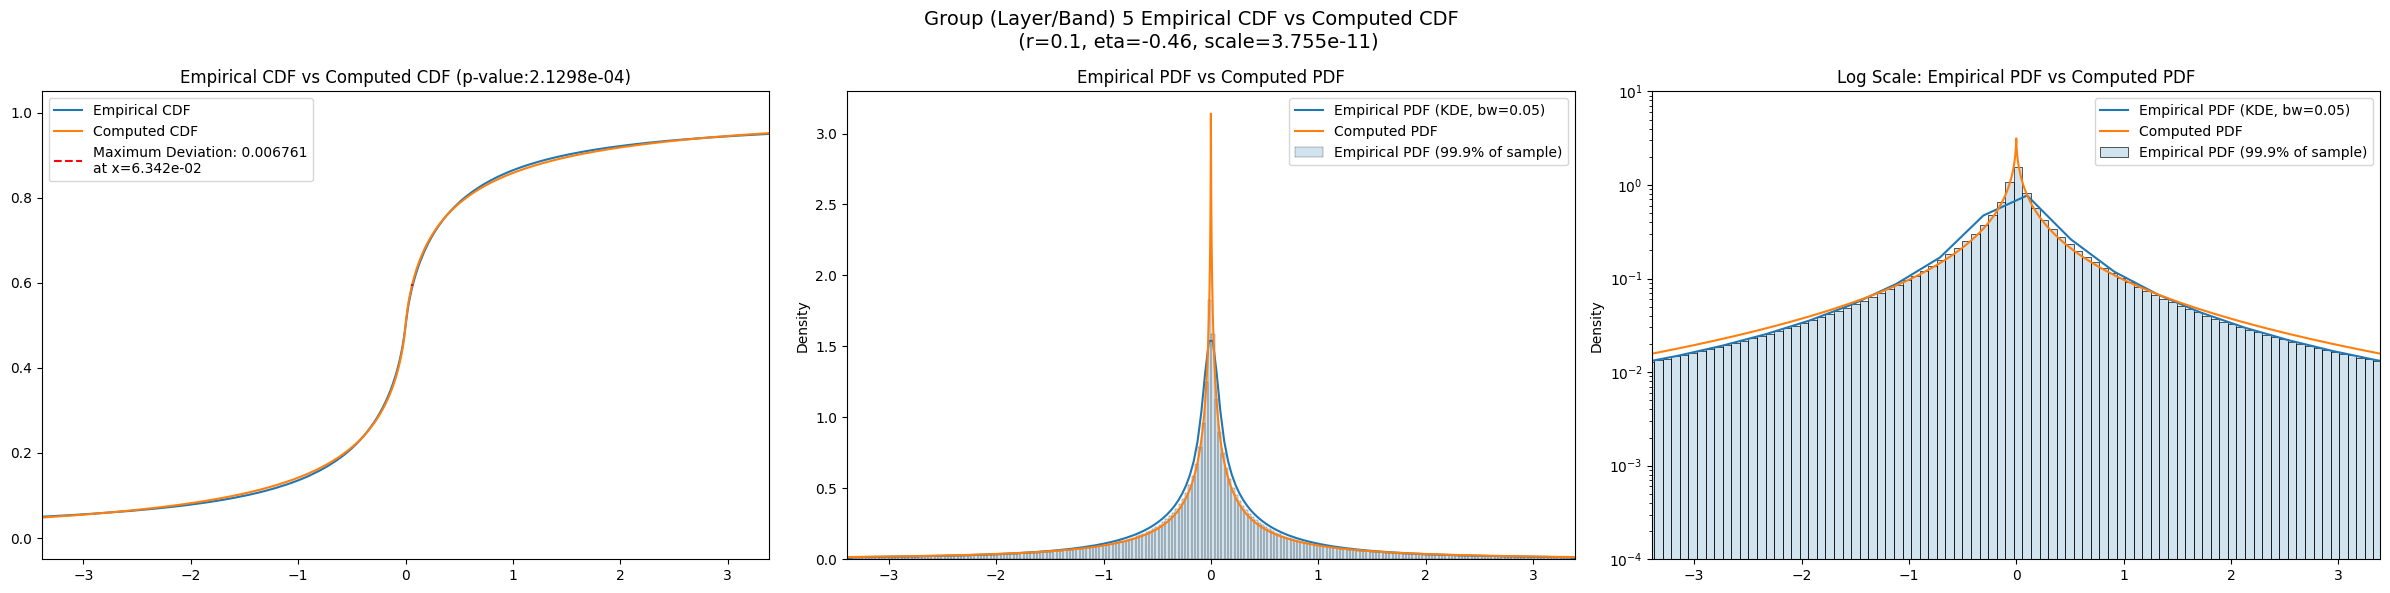

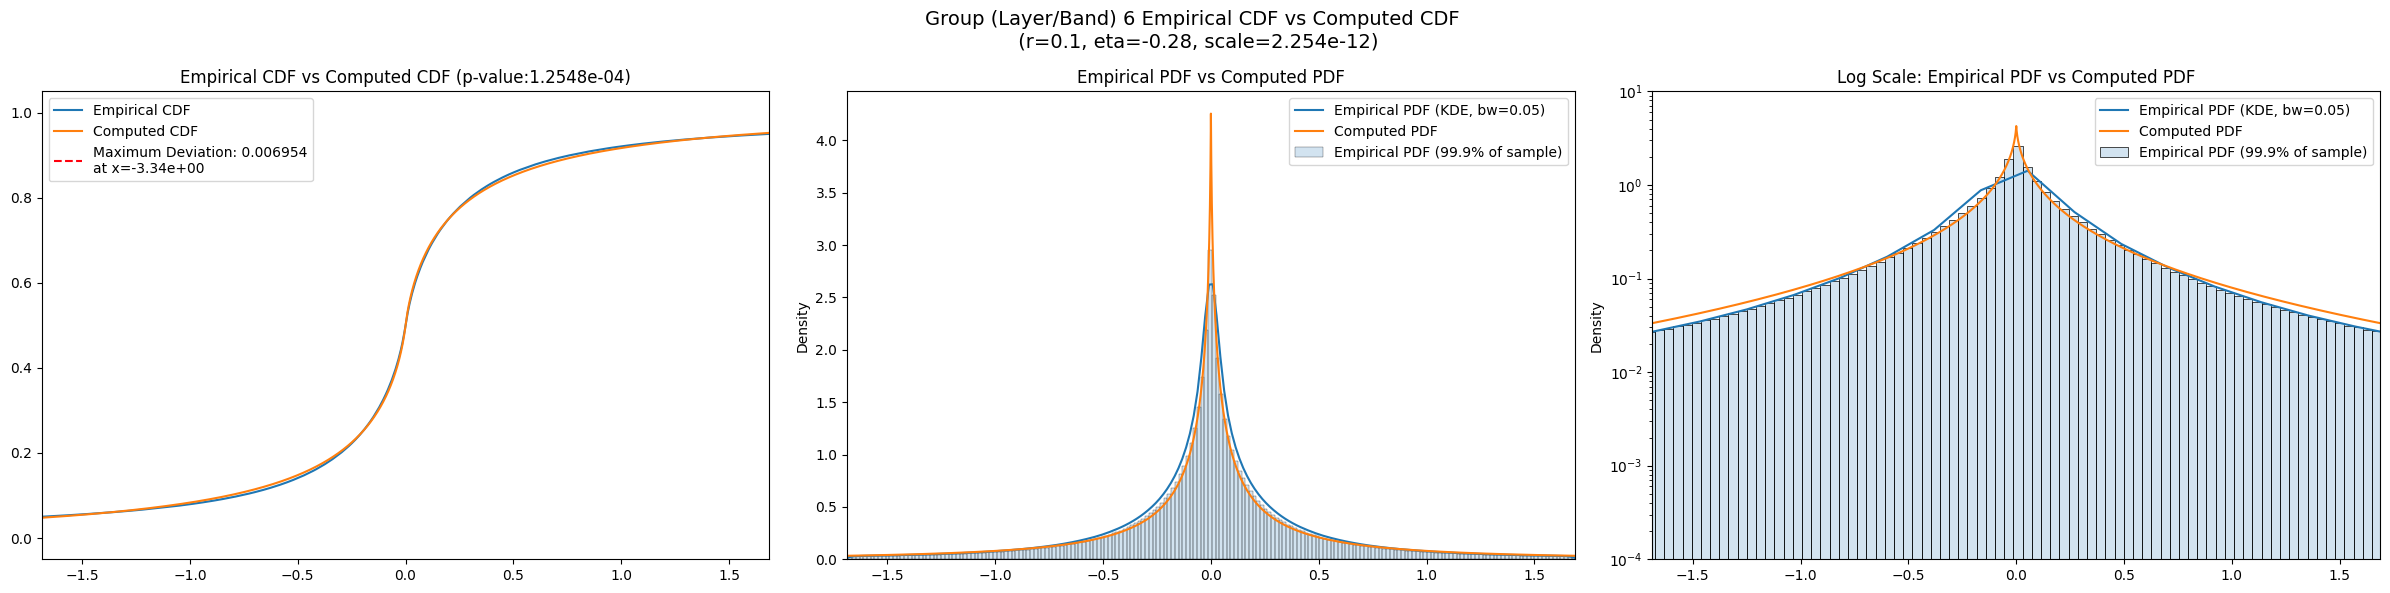

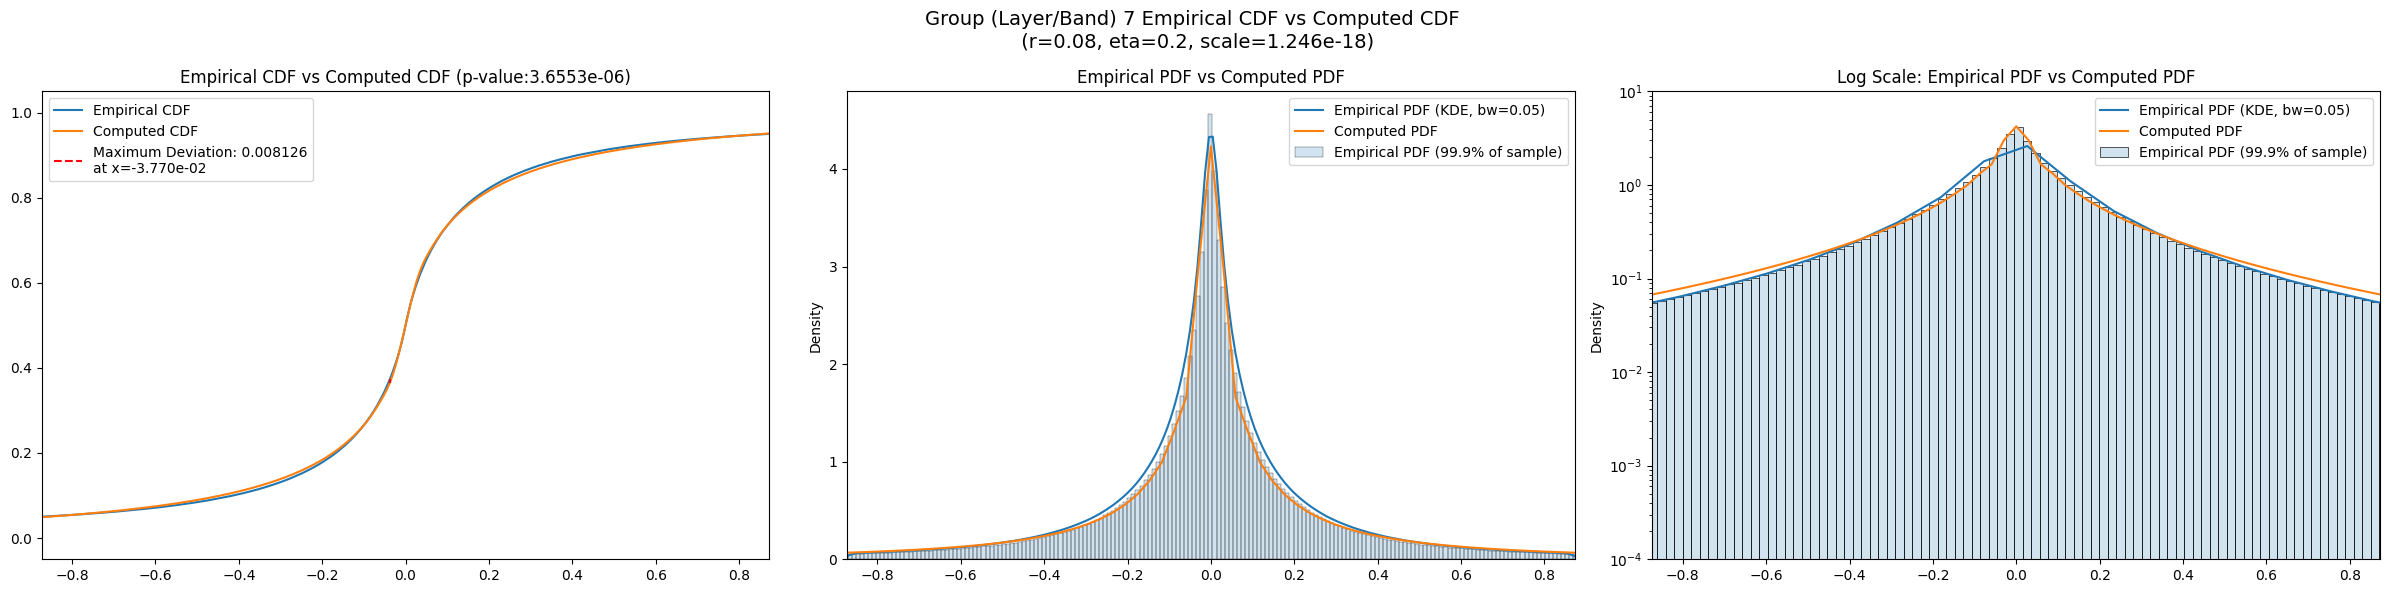

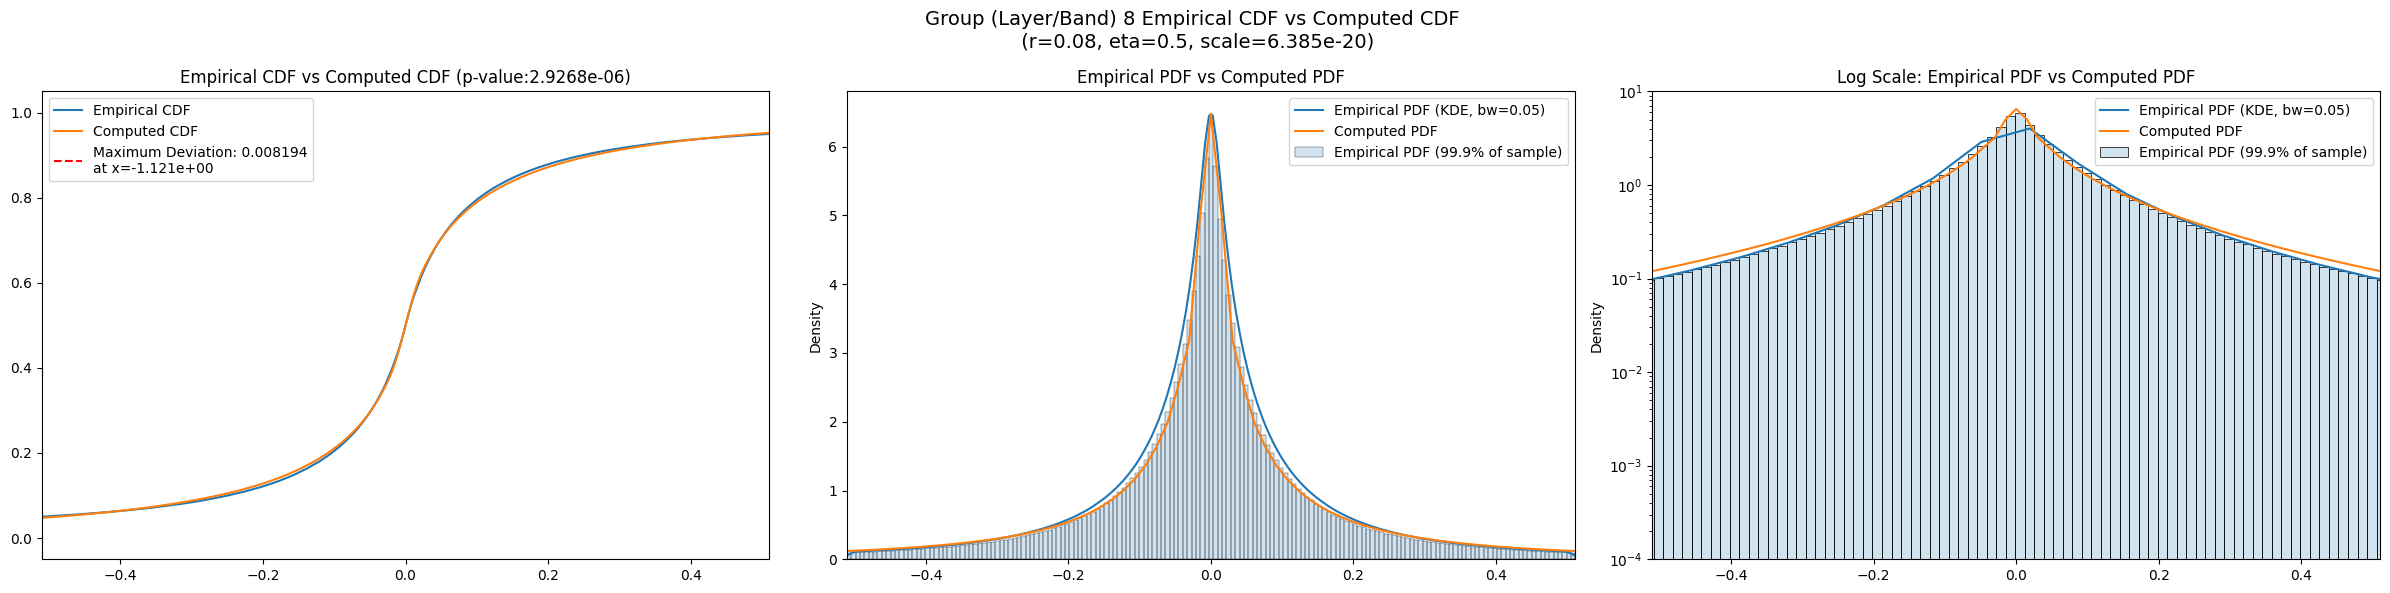

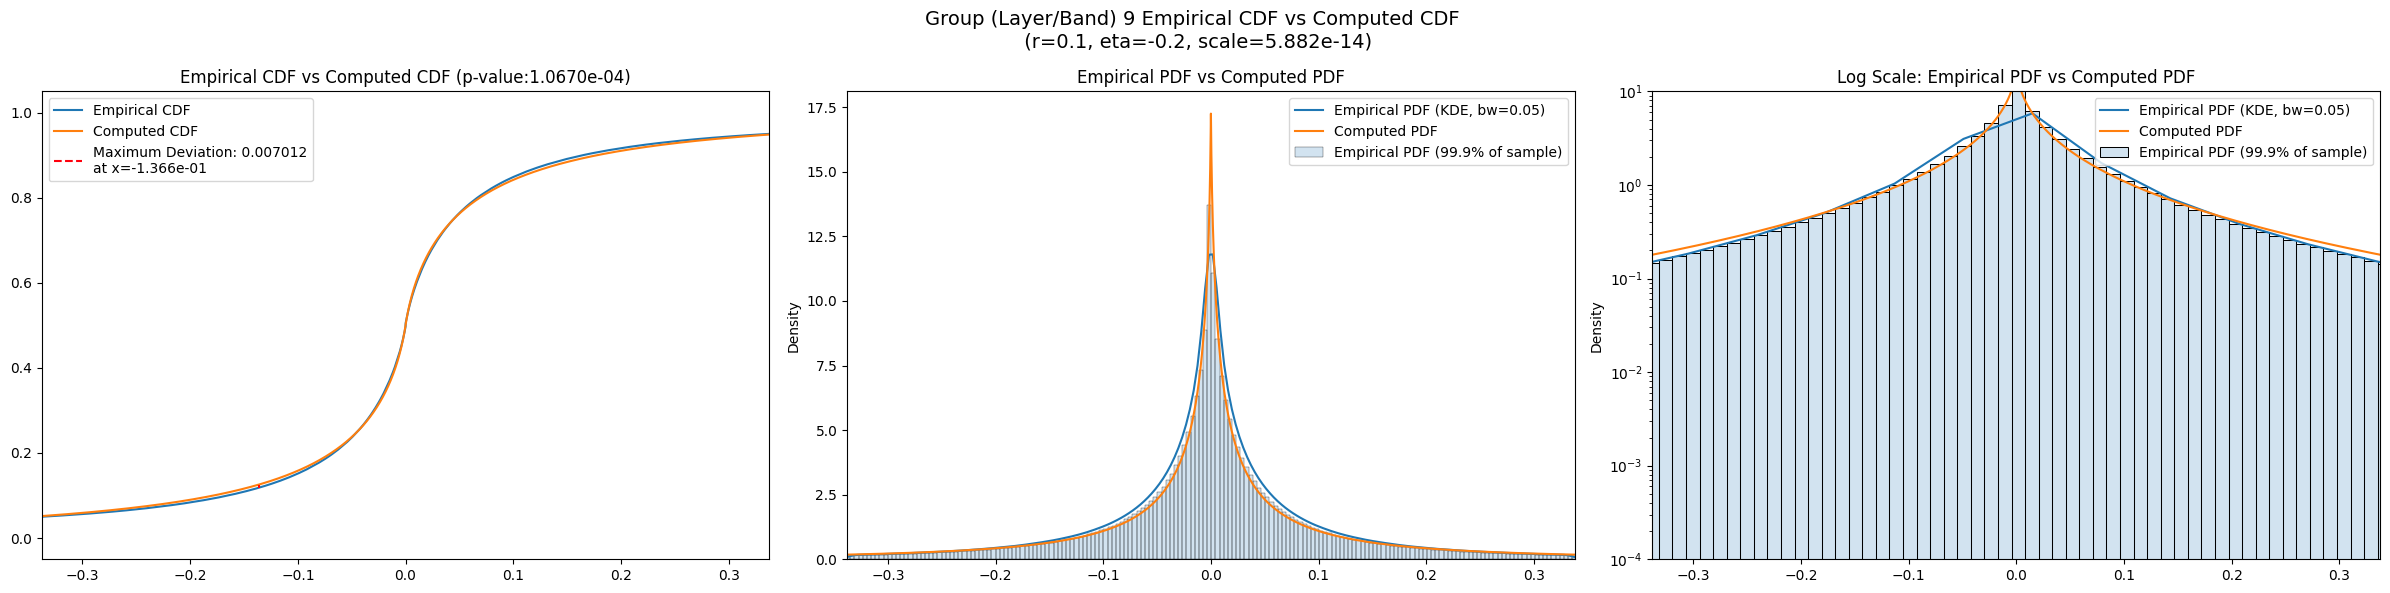

In [26]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [27]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [28]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     68.238930  55.853195  88.277690   78.60785   22.801790   260.92975   
3     29.261380  23.565706  41.711970  131.73262   23.337027   507.65482   
4     29.676050  23.769623  42.169933  130.15865   29.780775   507.69504   
5     16.709303  13.237209  24.569920  157.44476   33.269300   601.07715   
6      4.573166   3.469207   7.863290  323.61923   36.913420  1073.44250   
7      1.101603   0.858899   1.745578  222.43742   33.257880   816.22186   
8      0.427903   0.339047   0.593751  118.09703   37.517390   437.80756   
9      0.312102   0.231882   0.484675  221.03058   55.075670   742.60030   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2          100000.0             0.003414        0.4         -1.0  ...   
3          100000.0             0.002955        0.4         -1.0  ...   
4          100000.0             0.002614        0.2         -0.9  ...   
5          100000.0             0.007084        0.1         -0.4  ...   
6          100000.0             0.008049        0.1         -0.3  ...   
7          100000.0             0.007702        0.1         -0.1  ...   
8          100000.0             0.008906        0.1          0.1  ...   
9          100000.0             0.007952        0.1         -0.2  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           3.081250              0.066975                   0.0   
3           1.928860              0.070074                   0.0   
4           1.287700              0.081872                   0.0   
5           0.735884              0.079968                   0.0   
6           0.405272              0.074237                   0.0   
7           0.227696              0.070690                   0.0   
8           0.142357              0.067185                   0.0   
9           0.089547              0.071382                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.677410             0.041195        6.800190e-148  2.079080   
3          1.658300             0.044813        6.069580e-175  1.293630   
4          1.110370             0.057383        1.152550e-286  0.851262   
5          0.650902             0.056015        3.619420e-273  0.489988   
6          0.360920             0.050141        6.232020e-219  0.272191   
7          0.203351             0.046176        9.983460e-186  0.154599   
8          0.127514             0.042542        1.072380e-157  0.097484   
9          0.079297             0.046513        1.924310e-188  0.060413   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.041985  1.318970e-153              0.859909  
3          0.046477  3.733370e-188              0.973955  
4          0.057618  5.233120e-289              0.500818  
5          0.053666  9.323130e-251              0.000213  
6          0.047270  1.283350e-194              0.000125  
7          0.042957  8.736720e-161              0.000070  
8          0.038789  3.638970e-131              0.000003  
9          0.044439  4.809340e-172              0.000107  

[8 rows x 30 columns]

## Results

In [29]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [30]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003414                 0.004293          0.001906   
3                0.002955                 0.004293          0.001525   
4                0.002614                 0.004293          0.002614   
5                0.007084                 0.004293          0.006761   
6                0.008049                 0.004293          0.006955   
7                0.007702                 0.004293          0.007161   
8                0.008906                 0.004293          0.008195   
9                0.007952                 0.004293          0.007012   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.066975             0.041195       0.041985  
3                 0.070074             0.044813       0.046477  
4                 0.081872             0.057383       0.057618  
5                 0.079968             0.056015       0.053666  
6                 0.074237             0.050141       0.047270  
7                 0.070690             0.046176       0.042957  
8                 0.067185             0.042542       0.038789  
9                 0.071382             0.046513       0.044439

In [31]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2              55.518093          0.001906    0.30     -0.87  1.235275e+00   
3              22.331747          0.001525    0.37     -1.00  3.097345e+00   
4              25.607506          0.002614    0.20     -0.90  1.016171e-02   
5              16.709303          0.006761    0.10     -0.46  3.754895e-11   
6               3.266947          0.006955    0.10     -0.28  2.254099e-12   
7               0.868440          0.007161    0.08      0.20  1.246368e-18   
8               0.232064          0.008195    0.08      0.50  6.384768e-20   
9               0.138019          0.007012    0.10     -0.20  5.881789e-14   

      best_exclude_cutoff  
band                       
2                    50.0  
3                    75.0  
4                    25.0  
5                     0.0  
6                    75.0  
7                    50.0  
8                   275.0  
9                   275.0